# Importing Libraries

In [1]:
import datetime, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf


In [2]:
SEED = 548
BATCH_SIZE = 64
EPOCHS = 250
LEARNING_RATE = 0.13
IMAGE_SIZE = 112

In [3]:
img_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [4]:
train_ds = img_gen.flow_from_directory('../input/paddy-disease-classification/train_images',
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       shuffle=True, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       batch_size=BATCH_SIZE,
                                       subset="training")

classes = list(train_ds.class_indices.keys())

print('Classes: '+str(classes))

num_classes  = len(classes)

Found 9371 images belonging to 10 classes.
Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [5]:
val_ds = img_gen.flow_from_directory('../input/paddy-disease-classification/train_images',
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       shuffle=False, 
                                       seed=SEED,
                                       class_mode='categorical',
                                       batch_size=BATCH_SIZE,
                                       subset="validation")

Found 1036 images belonging to 10 classes.


In [6]:
test_ds = img_gen.flow_from_directory('../input/paddy-disease-classification/test_images',
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      classes=['.'],
                                      class_mode= None,
                                      batch_size=BATCH_SIZE)

Found 3469 images belonging to 1 classes.


In [7]:
nb_train_samples = train_ds.samples

steps_per_epoch = nb_train_samples // BATCH_SIZE

# EDA

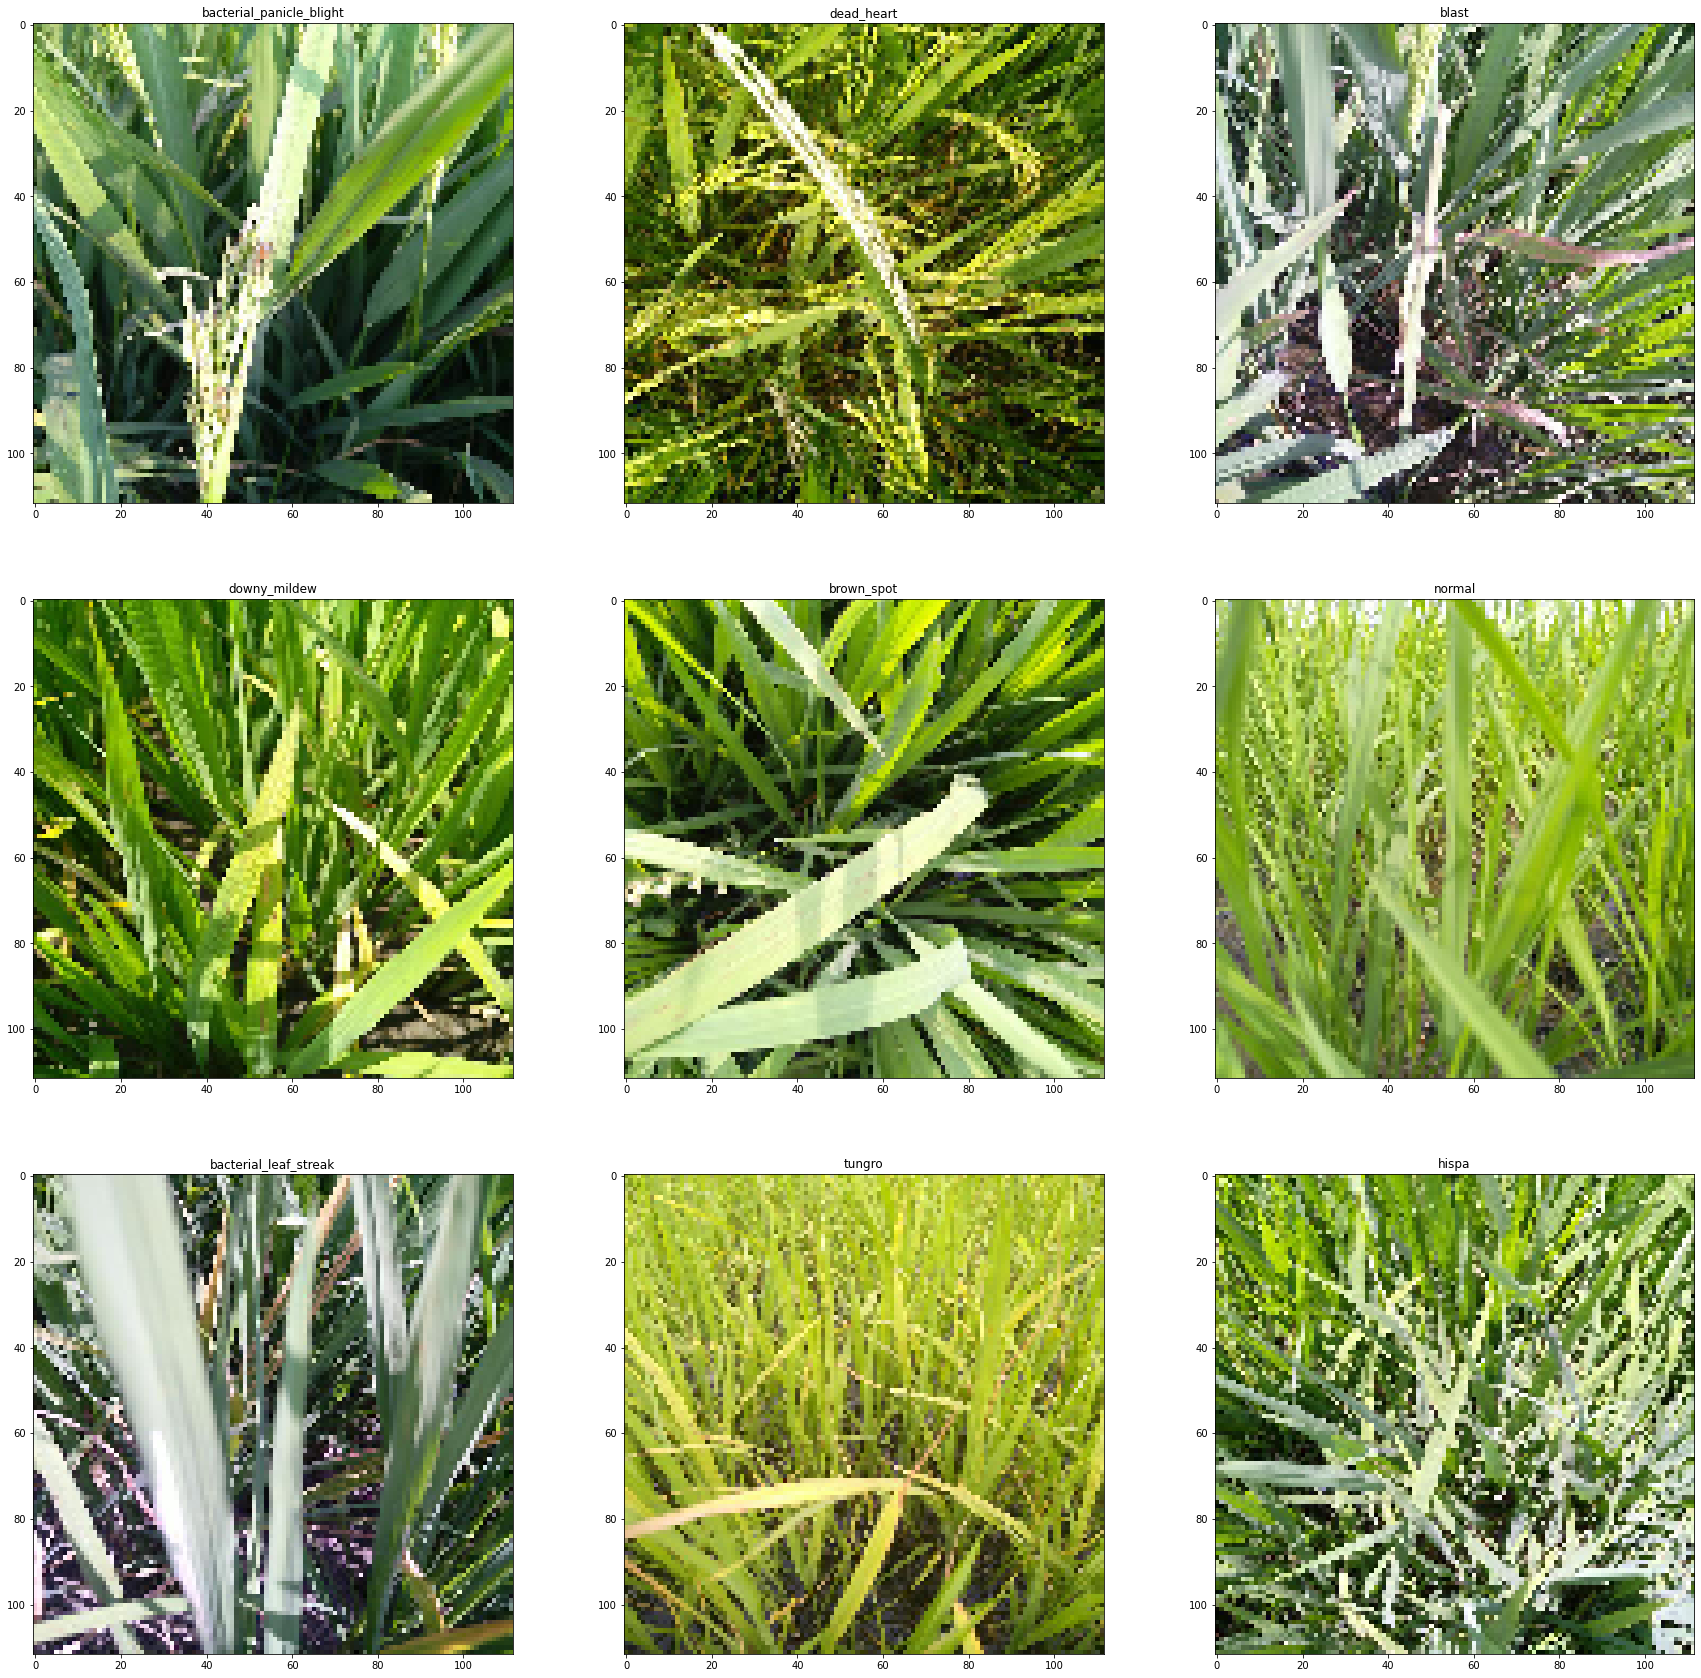

In [8]:
plt.figure(figsize=(30,30))
images = train_ds.next()*255
for i, (image, l) in enumerate(zip(images[0][:9],images[1][:9])):
    ax = plt.subplot(330 + 1 + i)
    ax.set_title( classes[np.argmax(l)] )
    plt.imshow(image)
plt.show()

# Training

In [9]:
model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(8192, activation='relu'),
tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
history = model.fit(
    train_ds,
    steps_per_epoch = steps_per_epoch,
    epochs = 15,
    validation_data = val_ds
)

#model.summary()

Epoch 1/15
146/146 [==============================] - 161s 1s/step - loss: 2.0523 - accuracy: 0.2471 - val_loss: 1.9073 - val_accuracy: 0.3571
Epoch 2/15
146/146 [==============================] - 106s 726ms/step - loss: 1.7388 - accuracy: 0.3958 - val_loss: 1.5735 - val_accuracy: 0.4585
Epoch 3/15
146/146 [==============================] - 106s 723ms/step - loss: 1.4847 - accuracy: 0.4920 - val_loss: 1.3346 - val_accuracy: 0.5473
Epoch 4/15
146/146 [==============================] - 105s 717ms/step - loss: 1.2438 - accuracy: 0.5809 - val_loss: 1.1530 - val_accuracy: 0.6091
Epoch 5/15
146/146 [==============================] - 105s 715ms/step - loss: 1.0043 - accuracy: 0.6660 - val_loss: 0.9797 - val_accuracy: 0.6805
Epoch 6/15
146/146 [==============================] - 105s 719ms/step - loss: 0.8076 - accuracy: 0.7372 - val_loss: 0.8807 - val_accuracy: 0.7181
Epoch 7/15
146/146 [==============================] - 106s 722ms/step - loss: 0.6469 - accuracy: 0.7924 - val_loss: 0.7470 - va

# Evaluation

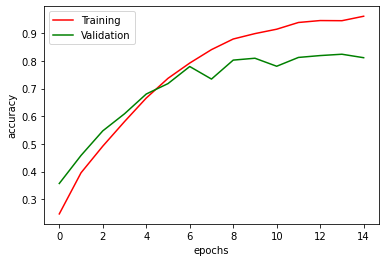

In [11]:
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="g")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

# Prediction

In [12]:
predict = model.predict(test_ds, verbose=1)

55/55 [==============================] - 50s 906ms/step


In [13]:
predicted_class_indices = np.argmax(predict,axis=1)
print(set(predicted_class_indices))

inv_map = {v:k for k,v in train_ds.class_indices.items()}

predictions = [inv_map[k] for k in predicted_class_indices]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [14]:
filenames = test_ds.filenames

submission = pd.DataFrame({ "image_id":filenames, "label":predictions })

submission.image_id = submission.image_id.str.replace('./', '')
submission.to_csv("submission.csv",index=False)
submission.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,bacterial_leaf_blight
1,200002.jpg,normal
2,200003.jpg,downy_mildew
3,200004.jpg,normal
4,200005.jpg,hispa


In [17]:
model.save('/kaggle/working/model.h5')